In [142]:
!python -V

Python 3.9.19


In [143]:
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error

Read in taxi data using pandas.

In [144]:
df = pd.read_parquet('../data/green_tripdata_2023-01.parquet')


Note that the dropoff/pickup time data has already datatime format, so there's no need to convert it

In [145]:
df.dtypes

VendorID                          int64
lpep_pickup_datetime     datetime64[us]
lpep_dropoff_datetime    datetime64[us]
store_and_fwd_flag               object
RatecodeID                      float64
PULocationID                      int64
DOLocationID                      int64
passenger_count                 float64
trip_distance                   float64
fare_amount                     float64
extra                           float64
mta_tax                         float64
tip_amount                      float64
tolls_amount                    float64
ehail_fee                        object
improvement_surcharge           float64
total_amount                    float64
payment_type                    float64
trip_type                       float64
congestion_surcharge            float64
dtype: object

In [146]:
col = df.columns
print('Number of columns: ', len(col))

Number of columns:  20


Now we calculate the duration of each trip

In [147]:
df['duration'] = df.lpep_dropoff_datetime - df.lpep_pickup_datetime

the duration is a full datetime bit with minutes and seconds:

In [148]:
df.duration

0       0 days 00:11:01
1       0 days 00:06:46
2       0 days 00:06:20
3       0 days 00:05:49
4       0 days 00:05:58
              ...      
68206   0 days 00:13:00
68207   0 days 00:08:00
68208   0 days 00:16:00
68209   0 days 00:18:00
68210   0 days 00:16:00
Name: duration, Length: 68211, dtype: timedelta64[us]

Since it is too granular, we just convert duration as a fraction of minutes

In [149]:
df.duration = df.duration.apply(lambda td: td.total_seconds() / 60)
df.duration

0        11.016667
1         6.766667
2         6.333333
3         5.816667
4         5.966667
           ...    
68206    13.000000
68207     8.000000
68208    16.000000
68209    18.000000
68210    16.000000
Name: duration, Length: 68211, dtype: float64

~~Now we filter by just getting any trips that were only street-hail (trip type 2)~~

turns out that filtering by only using street hail means that we have a lot of trips that last less than 1 minute. So we will just comment it out and keep both the street hail and the pre booked ones.

In [150]:
# df = df[df.trip_type == 2]
df

,VendorID,lpep_pickup_datetime,lpep_dropoff_datetime,store_and_fwd_flag,RatecodeID,PULocationID,DOLocationID,passenger_count,trip_distance,fare_amount,extra,mta_tax,tip_amount,tolls_amount,ehail_fee,improvement_surcharge,total_amount,payment_type,trip_type,congestion_surcharge,duration
0,2,2023-01-01 00:26:10,2023-01-01 00:37:11,N,1.0,166,143,1.0,2.58,14.90,1.0,0.5,4.03,0.0,None,1.0,24.18,1.0,1.0,2.75,11.016667
1,2,2023-01-01 00:51:03,2023-01-01 00:57:49,N,1.0,24,43,1.0,1.81,10.70,1.0,0.5,2.64,0.0,None,1.0,15.84,1.0,1.0,0.00,6.766667
2,2,2023-01-01 00:35:12,2023-01-01 00:41:32,N,1.0,223,179,1.0,0.00,7.20,1.0,0.5,1.94,0.0,None,1.0,11.64,1.0,1.0,0.00,6.333333
3,1,2023-01-01 00:13:14,2023-01-01 00:19:03,N,1.0,41,238,1.0,1.30,6.50,0.5,1.5,1.70,0.0,None,1.0,10.20,1.0,1.0,0.00,5.816667
4,1,2023-01-01 00:33:04,2023-01-01 00:39:02,N,1.0,41,74,1.0,1.10,6.00,0.5,1.5,0.00,0.0,None,1.0,8.00,1.0,1.0,0.00,5.966667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
68206,2,2023-01-31 22:29:00,2023-01-31 22:42:00,None,NaN,49,62,NaN,4070.82,15.70,0.0,0.0,0.00,0.0,None,1.0,16.70,NaN,NaN,NaN,13.000000
68207,2,2023-01-31 22:40:00,2023-01-31 22:48:00,None,NaN,10,205,NaN,2.14,4.41,0.0,0.0,0.00,0.0,None,1.0,5.41,NaN,NaN,NaN,8.000000
68208,2,2023-01-31 23:46:00,2023-02-01 00:02:00,None,NaN,66,37,NaN,3.44,16.53,0.0,0.0,3.51,0.0,None,1.0,21.04,NaN,NaN,NaN,16.000000
68209,2,2023-01-31 23:01:00,2023-01-31 23:19:00,None,NaN,225,189,NaN,3.03,14.98,0.0,0.0,3.20,0.0,None,1.0,19.18,NaN,NaN,NaN,18.000000


Now we plot the distribution of the duration using sns

/Users/andreanicolas/anaconda3/envs/mlops_env/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: xlabel='duration', ylabel='Count'>

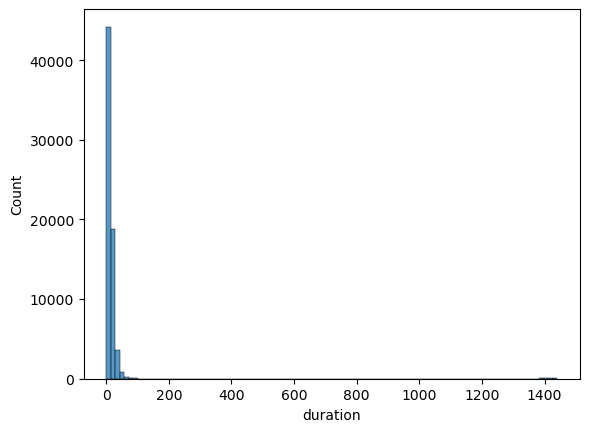

In [151]:
sns.histplot(df.duration,bins=100)

It has a bunch of outliers (max is days long, min is nonrunning trips), so the distribution can't be seen really well...

In [152]:
df.duration.describe()

count    68211.000000
mean        18.097271
std         74.925631
min          0.000000
25%          7.216667
50%         11.400000
75%         17.483333
max       1439.883333
Name: duration, dtype: float64

We will filter so that we only keep data betwen 1 and 60 mins (inclusive)

In [153]:
mask = ((df.duration >=1) & (df.duration<=60))
total_n = len(mask)
filtered_n = mask.sum()
print(f'percentage left after dropping outliers is {filtered_n/total_n*100:.2f}%')

percentage left after dropping outliers is 96.68%


In [154]:
df = df[mask]
df

,VendorID,lpep_pickup_datetime,lpep_dropoff_datetime,store_and_fwd_flag,RatecodeID,PULocationID,DOLocationID,passenger_count,trip_distance,fare_amount,extra,mta_tax,tip_amount,tolls_amount,ehail_fee,improvement_surcharge,total_amount,payment_type,trip_type,congestion_surcharge,duration
0,2,2023-01-01 00:26:10,2023-01-01 00:37:11,N,1.0,166,143,1.0,2.58,14.90,1.0,0.5,4.03,0.0,None,1.0,24.18,1.0,1.0,2.75,11.016667
1,2,2023-01-01 00:51:03,2023-01-01 00:57:49,N,1.0,24,43,1.0,1.81,10.70,1.0,0.5,2.64,0.0,None,1.0,15.84,1.0,1.0,0.00,6.766667
2,2,2023-01-01 00:35:12,2023-01-01 00:41:32,N,1.0,223,179,1.0,0.00,7.20,1.0,0.5,1.94,0.0,None,1.0,11.64,1.0,1.0,0.00,6.333333
3,1,2023-01-01 00:13:14,2023-01-01 00:19:03,N,1.0,41,238,1.0,1.30,6.50,0.5,1.5,1.70,0.0,None,1.0,10.20,1.0,1.0,0.00,5.816667
4,1,2023-01-01 00:33:04,2023-01-01 00:39:02,N,1.0,41,74,1.0,1.10,6.00,0.5,1.5,0.00,0.0,None,1.0,8.00,1.0,1.0,0.00,5.966667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
68206,2,2023-01-31 22:29:00,2023-01-31 22:42:00,None,NaN,49,62,NaN,4070.82,15.70,0.0,0.0,0.00,0.0,None,1.0,16.70,NaN,NaN,NaN,13.000000
68207,2,2023-01-31 22:40:00,2023-01-31 22:48:00,None,NaN,10,205,NaN,2.14,4.41,0.0,0.0,0.00,0.0,None,1.0,5.41,NaN,NaN,NaN,8.000000
68208,2,2023-01-31 23:46:00,2023-02-01 00:02:00,None,NaN,66,37,NaN,3.44,16.53,0.0,0.0,3.51,0.0,None,1.0,21.04,NaN,NaN,NaN,16.000000
68209,2,2023-01-31 23:01:00,2023-01-31 23:19:00,None,NaN,225,189,NaN,3.03,14.98,0.0,0.0,3.20,0.0,None,1.0,19.18,NaN,NaN,NaN,18.000000


Now we set the categorical and numerical variables to use

In [155]:
categorical = ['PULocationID', 'DOLocationID'] # pickup and dropoff location
numerical = ['trip_distance'] # distance of trip
df[categorical].dtypes #int64

PULocationID    int64
DOLocationID    int64
dtype: object

Now we will do one hot encoding (converting things to 0s and 1s).
First we will convert the categoricals to just objects

In [156]:
df[categorical] = df[categorical].astype(str)
df[categorical].dtypes #object

/var/folders/fm/8gkkcxbn0y3896pxrr1p0nqh0000gn/T/ipykernel_37140/707467286.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[categorical] = df[categorical].astype(str)


PULocationID    object
DOLocationID    object
dtype: object

We convert each row to a dictionary, and we will use the dictionary vectorizer to convert the dictionary to just vectors.

In [157]:
train_dicts = df[categorical + numerical].to_dict(orient='records')

In [158]:
train_dicts[:10]

[{'PULocationID': '166', 'DOLocationID': '143', 'trip_distance': 2.58},
 {'PULocationID': '24', 'DOLocationID': '43', 'trip_distance': 1.81},
 {'PULocationID': '223', 'DOLocationID': '179', 'trip_distance': 0.0},
 {'PULocationID': '41', 'DOLocationID': '238', 'trip_distance': 1.3},
 {'PULocationID': '41', 'DOLocationID': '74', 'trip_distance': 1.1},
 {'PULocationID': '41', 'DOLocationID': '262', 'trip_distance': 2.78},
 {'PULocationID': '181', 'DOLocationID': '45', 'trip_distance': 3.8},
 {'PULocationID': '24', 'DOLocationID': '75', 'trip_distance': 1.88},
 {'PULocationID': '41', 'DOLocationID': '166', 'trip_distance': 1.11},
 {'PULocationID': '24', 'DOLocationID': '140', 'trip_distance': 4.22}]

In [159]:
dv = DictVectorizer()
X_train = dv.fit_transform(train_dicts)

we can check the no of columns and the feature names for each column

In [160]:
dv.feature_names_[:20]

['DOLocationID=1',
 'DOLocationID=10',
 'DOLocationID=100',
 'DOLocationID=101',
 'DOLocationID=102',
 'DOLocationID=106',
 'DOLocationID=107',
 'DOLocationID=108',
 'DOLocationID=11',
 'DOLocationID=111',
 'DOLocationID=112',
 'DOLocationID=113',
 'DOLocationID=114',
 'DOLocationID=115',
 'DOLocationID=116',
 'DOLocationID=117',
 'DOLocationID=119',
 'DOLocationID=12',
 'DOLocationID=120',
 'DOLocationID=121']

In [161]:
print(f'no of columns on one hot: {X_train.shape[1]}')

no of columns on one hot: 468
